![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Stochastic Gradient Descent (SGD) - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainSGD_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(0)

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/03_OptimizationMethods/SGD_Aux.py

In [5]:
#-- What we have so far:
from SGD_Aux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Accuracy

#### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTrainSet.classes
mTrainX  = oTrainSet.data.view(-1,784).numpy() / 255
mTestX   = oTestSet .data.view(-1,784).numpy() / 255
vTrainY  = oTrainSet.targets.numpy()
vTestY   = oTestSet .targets.numpy()

(
mTrainX.shape, 
vTrainY.shape, 
mTestX .shape,  
vTestY .shape
)

((60000, 784), (60000,), (10000, 784), (10000,))

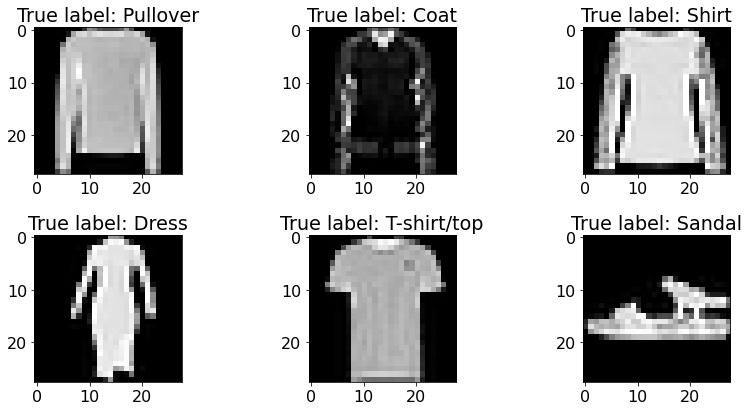

In [7]:
#-- Plot a few examples:
N, d   = mTrainX.shape
fig, _ = plt.subplots(2, 3, figsize=(12, 6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mTrainX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTrainY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [8]:
vMean = mTrainX.mean(0)
vStd  = mTrainX.std (0)

mTrainX -= vMean
mTestX  -= vMean
mTrainX /= vStd
mTestX  /= vStd

### Exercise
* Add a drop last flag (`bDropLast`):
    * If `bDropLast = False` then the last non-full batch is also returned in the iterations.
* Update `TrainEpoch` and `ValidationEpoch` accordingly

**Extra**: Play with the model (and the hyper-parameters) and improve your validation accuracy.

In [9]:
class Dataset:
    def __init__(self, mX, vY, batchSize, bDropLast=False):
        self.mX        = mX
        self.vY        = vY
        self.N         = len(vY)
        self.batchSize = min(batchSize, self.N)
        self.nBatches  = np.ceil(self.N / self.batchSize).astype(np.int32)

    def __len__(self):
        return self.nBatches

    #-- Loop over mini-batches:
    def __iter__(self):
        vIdx = np.random.permutation(self.N)

        for ii in range(self.nBatches):
            startIdx  = ii * self.batchSize
            vBatchIdx = vIdx[startIdx : startIdx + self.batchSize]
            mBatchX   = self.mX[:,vBatchIdx]
            vBatchY   = self.vY[vBatchIdx]

            yield mBatchX, vBatchY

In [10]:
batchSize = 256
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oTestSet  = Dataset(mTestX.T,  vTestY,  batchSize)

#### Test your implementation
You should get $4$ batches, where the last one is not full.

In [11]:
batchSize = 15
oDataset  = Dataset(mTrainX[:55,:].T, vTrainY[:55], batchSize)
for ii, (mXi, vYi) in enumerate(oDataset):
    print(f'mX_{ii}.shape = {mXi.shape}, vY_{ii}.shape = {vYi.shape}')
    
print(f'Dataset length = {len(oDataset)}')

mX_0.shape = (784, 15), vY_0.shape = (15,)
mX_1.shape = (784, 15), vY_1.shape = (15,)
mX_2.shape = (784, 15), vY_2.shape = (15,)
mX_3.shape = (784, 10), vY_3.shape = (10,)
Dataset length = 4


#### Update `TrainEpoch` and `ValidationEpoch`
* Remember that each mini-batch might be of a different size.
* Use `len(vY)` to get the current batch size.

In [12]:
import time

def TrainEpoch(oModel, oTrainData, learningRate):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0

    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oTrainData):
        
        Nb     = len(vY) #-- currect batch size
        count += Nb
        
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        #-- Backward:
        oModel.Backward(mDz)

        #-- Update parameters (stochasitc gradient descnet):
        for oLayer in oModel.lLayers:
            for sParam in oLayer.dGrads:
                oLayer.dParams[sParam] -= learningRate * oLayer.dGrads[sParam]
        
        epochLoss += Nb * loss
        epochAcc  += Nb * Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= count
    epochAcc  /= count
    
    return epochLoss, epochAcc

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def ValidationEpoch(oModel, oValData):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oValData):
        
        Nb     = len(vY) #-- currect batch size
        count += Nb
        
        #-- Forward:
        mZ      = oModel.Forward(mX)
        loss, _ = CrossEntropyLoss(vY, mZ)
               
        epochLoss += Nb * loss
        epochAcc  += Nb * Accuracy(mZ, vY)
    
    epochLoss /= count
    epochAcc  /= count
    
    return epochLoss, epochAcc

#### Train model function:

In [13]:
def TrainModel(oModel, oTrainData, oValData, numEpochs, learningRate):
    for epoch in range(numEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = TrainEpoch     (oModel, oTrainData, learningRate) #-- train
        valLoss,   valAcc   = ValidationEpoch(oModel, oValData)                 #-- validation
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :3d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}', end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}', end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}', end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}', end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |')

#### Improve your accuracy:

In [14]:
oModel = SequentialModel([
        LinearLayer(784, 200), ReLULayer(),
        LinearLayer(200,  10, init='Xavier'),
])

nEpochs = 100
lr      = 2e-2

TrainModel(oModel, oTrainSet, oTestSet, nEpochs, lr)

Epoch   0: | Train loss:  0.749 | Val loss:  0.579 | Train Accuracy:  0.746 | Val Accuracy:  0.797 | epoch time:  0.765 |
Epoch   1: | Train loss:  0.499 | Val loss:  0.499 | Train Accuracy:  0.825 | Val Accuracy:  0.825 | epoch time:  0.764 |
Epoch   2: | Train loss:  0.445 | Val loss:  0.467 | Train Accuracy:  0.844 | Val Accuracy:  0.834 | epoch time:  0.767 |
Epoch   3: | Train loss:  0.417 | Val loss:  0.449 | Train Accuracy:  0.854 | Val Accuracy:  0.841 | epoch time:  0.781 |
Epoch   4: | Train loss:  0.397 | Val loss:  0.435 | Train Accuracy:  0.861 | Val Accuracy:  0.844 | epoch time:  0.722 |
Epoch   5: | Train loss:  0.382 | Val loss:  0.424 | Train Accuracy:  0.865 | Val Accuracy:  0.848 | epoch time:  0.780 |
Epoch   6: | Train loss:  0.371 | Val loss:  0.415 | Train Accuracy:  0.869 | Val Accuracy:  0.853 | epoch time:  0.751 |
Epoch   7: | Train loss:  0.361 | Val loss:  0.411 | Train Accuracy:  0.873 | Val Accuracy:  0.853 | epoch time:  0.740 |
Epoch   8: | Train loss:

Epoch  67: | Train loss:  0.184 | Val loss:  0.341 | Train Accuracy:  0.938 | Val Accuracy:  0.881 | epoch time:  0.767 |
Epoch  68: | Train loss:  0.183 | Val loss:  0.335 | Train Accuracy:  0.939 | Val Accuracy:  0.883 | epoch time:  0.755 |
Epoch  69: | Train loss:  0.181 | Val loss:  0.336 | Train Accuracy:  0.938 | Val Accuracy:  0.882 | epoch time:  0.726 |
Epoch  70: | Train loss:  0.179 | Val loss:  0.335 | Train Accuracy:  0.939 | Val Accuracy:  0.883 | epoch time:  0.755 |
Epoch  71: | Train loss:  0.178 | Val loss:  0.334 | Train Accuracy:  0.940 | Val Accuracy:  0.885 | epoch time:  0.748 |
Epoch  72: | Train loss:  0.176 | Val loss:  0.337 | Train Accuracy:  0.941 | Val Accuracy:  0.884 | epoch time:  0.767 |
Epoch  73: | Train loss:  0.175 | Val loss:  0.339 | Train Accuracy:  0.942 | Val Accuracy:  0.881 | epoch time:  0.770 |
Epoch  74: | Train loss:  0.173 | Val loss:  0.336 | Train Accuracy:  0.942 | Val Accuracy:  0.884 | epoch time:  0.765 |
Epoch  75: | Train loss:

Test accuracy: 88.5%


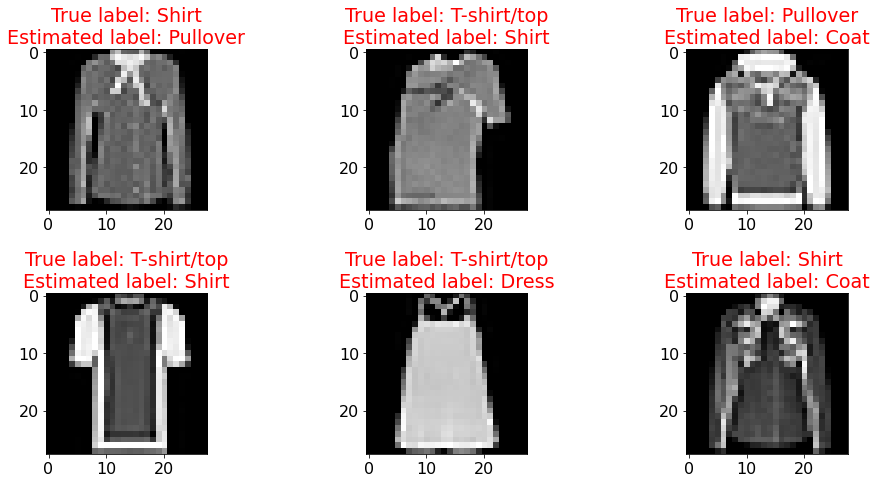

In [15]:
#-- Apply model to data:
mHatTestY = oModel.Forward(mTestX.T)
print(f'Test accuracy: {100 * Accuracy(mHatTestY, vTestY)}%')

#-- Plot a few mistakes:
vHatTestY = np.argmax(mHatTestY, axis=0)
vWrongIdx = np.nonzero(vTestY != vHatTestY)[0]

N, d   = mTestX.shape
fig, _ = plt.subplots(2, 3, figsize=(14, 7))
for ax in fig.axes:
    idx = vWrongIdx[np.random.randint(0, len(vWrongIdx))]
    ax.imshow   (np.reshape(mTestX[idx,:] * vStd + vMean, (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTestY[idx]]}\nEstimated label: {lClasses[vHatTestY[idx]]}', color='r')
    
plt.tight_layout()
plt.show()